# Homework 1 - Data Wrangling with Hadoop

The goal of this assignment is to put into action the data wrangling techniques from the exercises of week-3 and week-4. We highly suggest you to finish these two exercises first and then start the homework. In this homework, we are going to reuse the same __sbb__ dataset as we see in two exercises. 

Try to use as much as HiveQL as possible and use pandas operations only when it's necessary.

__Hand-in:__
- __Due: 24.03.2020 23:59 CET__
- `git push` your final verion to your group's Renku repository before the due
- check if `Dockerfile`, `environment.yml` and `requirements.txt` are properly written
- add necessary comments and discussion to make your queries readable


__Cluster Usage__

As there are many of you working with the cluster, we encourage you to prototype your queries on small data samples before running them on whole datasets.

__Documentation__

Hive queries: <https://cwiki.apache.org/confluence/display/Hive/LanguageManual+Select>

Hive functions: <https://cwiki.apache.org/confluence/display/Hive/LanguageManual+UDF>


In [1]:
import os
import pandas as pd
pd.set_option("display.max_columns", 50)
import matplotlib.pyplot as plt
%matplotlib inline

from pyhive import hive
username = os.environ['JUPYTERHUB_USER']
# create connection
conn = hive.connect(host='iccluster059.iccluster.epfl.ch', port=10000, username=username) 
# create cursor
cur = conn.cursor()

## Data from SBB/CFF/FFS

Data source: <https://opentransportdata.swiss/en/dataset/istdaten>

In this part, you will leverage Hive to perform exploratory analysis of data published by the [Open Data Platform Swiss Public Transport](https://opentransportdata.swiss).

Format: the dataset is originally presented as a collection of textfiles with fields separated by ';' (semi-colon). For efficiency, the textfiles have been compressed into Optimized Row Columnar ([ORC](https://cwiki.apache.org/confluence/display/Hive/LanguageManual+ORC)) file format. 

Location: you can find the data in ORC format on HDFS at the path `/data/sbb/orc/istdaten`.

The full description from opentransportdata.swiss can be found in <https://opentransportdata.swiss/de/cookbook/ist-daten/> in four languages. Because of the translation typos there may be some misunderstandings. We suggest you rely on the German version and use an automated translator when necessary. We will clarify if there is still anything unclear in class and Slack. Here are the relevant column descriptions:

- `BETRIEBSTAG`: date of the trip
- `FAHRT_BEZEICHNER`: identifies the trip
- `BETREIBER_ABK`, `BETREIBER_NAME`: operator (name will contain the full name, e.g. Schweizerische Bundesbahnen for SBB)
- `PRODUKT_ID`: type of transport, e.g. train, bus
- `LINIEN_ID`: for trains, this is the train number
- `LINIEN_TEXT`,`VERKEHRSMITTEL_TEXT`: for trains, the service type (IC, IR, RE, etc.)
- `ZUSATZFAHRT_TF`: boolean, true if this is an additional trip (not part of the regular schedule)
- `FAELLT_AUS_TF`: boolean, true if this trip failed (cancelled or not completed)
- `HALTESTELLEN_NAME`: name of the stop
- `ANKUNFTSZEIT`: arrival time at the stop according to schedule
- `AN_PROGNOSE`: actual arrival time
- `AN_PROGNOSE_STATUS`: show how the actual arrival time is calcluated
- `ABFAHRTSZEIT`: departure time at the stop according to schedule
- `AB_PROGNOSE`: actual departure time
- `AB_PROGNOSE_STATUS`: show how the actual departure time is calcluated
- `DURCHFAHRT_TF`: boolean, true if the transport does not stop there

Each line of the file represents a stop and contains arrival and departure times. When the stop is the start or end of a journey, the corresponding columns will be empty (`ANKUNFTSZEIT`/`ABFAHRTSZEIT`).

In some cases, the actual times were not measured so the `AN_PROGNOSE_STATUS`/`AB_PROGNOSE_STATUS` will be empty or set to `PROGNOSE` and `AN_PROGNOSE`/`AB_PROGNOSE` will be empty.

### Get yourself ready

If you have gone through the exercises by yourself, you are free to go for the questions. If you haven't gone through the exercises, you can follow the next two cells to get all your databases and tables ready.

__In Shell__:

```bash
hdfs dfs -mkdir   -p                              /user/${JUPYTERHUB_USER}/hive

hdfs dfs -setfacl -m    user:hive:r-x             /user/${JUPYTERHUB_USER}

hdfs dfs -setfacl -R -m group::r-x                /user/${JUPYTERHUB_USER}

hdfs dfs -setfacl -R -m other::---                /user/${JUPYTERHUB_USER}

hdfs dfs -setfacl -R -m default:group::r-x        /user/${JUPYTERHUB_USER}

hdfs dfs -setfacl -R -m default:other::---        /user/${JUPYTERHUB_USER}

hdfs dfs -setfacl -m    user:hive:rwx             /user/${JUPYTERHUB_USER}/hive

hdfs dfs -setfacl -m    default:user:hive:rwx     /user/${JUPYTERHUB_USER}/hive
```

__In Python__:
```python
# Drop your database
query = """
    drop database if exists {0} cascade
""".format(username)
cur.execute(query)

# Create your database
query = """
    create database {0} location "/user/{0}/hive"
""".format(username)
cur.execute(query)

# Drop the sbb table
query = """
    drop table if exists {0}.sbb_orc
""".format(username)
cur.execute(query)

# Create the sbb table
query = """
    create external table {0}.sbb_orc(
        BETRIEBSTAG string,
        FAHRT_BEZEICHNER string,
        BETREIBER_ID string,
        BETREIBER_ABK string,
        BETREIBER_NAME string,
        PRODUKT_ID string,
        LINIEN_ID string,
        LINIEN_TEXT string,
        UMLAUF_ID string,
        VERKEHRSMITTEL_TEXT string,
        ZUSATZFAHRT_TF string,
        FAELLT_AUS_TF string,
        BPUIC string,
        HALTESTELLEN_NAME string,
        ANKUNFTSZEIT string,
        AN_PROGNOSE string,
        AN_PROGNOSE_STATUS string,
        ABFAHRTSZEIT string,
        AB_PROGNOSE string,
        AB_PROGNOSE_STATUS string,
        DURCHFAHRT_TF string
    )
    row format delimited fields terminated by ';'
    stored as ORC
    location '/data/sbb/orc/istdaten'
    tblproperties ("skip.header.line.count"="1")
""".format(username)
cur.execute(query)

# Drop the table of one day
query = """
    drop table if exists {0}.sbb_05_11_2018
""".format(username)
cur.execute(query)

# Create the table of one day
query = """
    create table {0}.sbb_05_11_2018
    stored as orc
    as 
        select *
        from {0}.sbb_orc
        where BETRIEBSTAG like '05_11_2018'
""".format(username)
cur.execute(query)
```

In [2]:
# Drop your database
query = """
    drop database if exists {0} cascade
""".format(username)
cur.execute(query)

# Create your database
query = """
    create database {0} location "/user/{0}/hive"
""".format(username)
cur.execute(query)

# Drop the sbb table
query = """
    drop table if exists {0}.sbb_orc
""".format(username)
cur.execute(query)

# Create the sbb table
query = """
    create external table {0}.sbb_orc(
        BETRIEBSTAG string,
        FAHRT_BEZEICHNER string,
        BETREIBER_ID string,
        BETREIBER_ABK string,
        BETREIBER_NAME string,
        PRODUKT_ID string,
        LINIEN_ID string,
        LINIEN_TEXT string,
        UMLAUF_ID string,
        VERKEHRSMITTEL_TEXT string,
        ZUSATZFAHRT_TF string,
        FAELLT_AUS_TF string,
        BPUIC string,
        HALTESTELLEN_NAME string,
        ANKUNFTSZEIT string,
        AN_PROGNOSE string,
        AN_PROGNOSE_STATUS string,
        ABFAHRTSZEIT string,
        AB_PROGNOSE string,
        AB_PROGNOSE_STATUS string,
        DURCHFAHRT_TF string
    )
    row format delimited fields terminated by ';'
    stored as ORC
    location '/data/sbb/orc/istdaten'
    tblproperties ("skip.header.line.count"="1")
""".format(username)
cur.execute(query)

# Drop the table of one day
query = """
    drop table if exists {0}.sbb_05_11_2018
""".format(username)
cur.execute(query)

# Create the table of one day
query = """
    create table {0}.sbb_05_11_2018
    stored as orc
    as 
        select *
        from {0}.sbb_orc
        where BETRIEBSTAG like '05_11_2018'
""".format(username)
cur.execute(query)

### Question I.a - 5 Points

In the exercise, you were asked to find how many stops of each type of transportation for the date 05.11.2018. Now, let's do the same for the whole dataset. 

Show the results with a stacked bar chart (you can use `pandas` to create a pivot table if necessary). Document any patterns you can see.

__Hint__: 
- To properly order by date, you may have to parse them using the `unix_timestamp` function.
- When using `pd.read_sql(query, conn, ...)` to retrieve the query results, there is one `parse_dates` argument for date parsing.
- If you think it is not nice to display all the data in one plot, you can select a small period of data, i.e. 3 months, for visualization to detect the pattern.

### Question I.b - 10 Points

Get the set of IC (`VERKEHRSMITTEL_TEXT`) trains you can take to go (without connections) from Genève to Lausanne on a typical week day (not Saturday, not Sunday, not a bank holiday). Display the train number (`LINIEN_ID`) as well as the schedule of the trains.

__Note:__ do not hesitate to create intermediary tables. You can use the advanced search of SBB's website to check your answer, the schedule of IC from Genève to Lausanne has not changed.

In [5]:
# Create the table of one day which is not weekend or special day
query = """
    create table {0}.sbb_05_11_2019
    stored as orc
    as 
        select *
        from {0}.sbb_orc
        where BETRIEBSTAG like '05_11_2019'
""".format(username)
cur.execute(query)

#Actual Query, take unix time to sort the schedule, departure is from Geneve and time is taken as expected
#Second query selects the trains with type IC and sort them regarding their departure times.
query = """
    with Times as(
        select upper(VERKEHRSMITTEL_TEXT) as stype, 
               unix_timestamp(ABFAHRTSZEIT, 'dd.MM.yyy HH:mm') as expected_unix, 
               ABFAHRTSZEIT as expected,
               ZUSATZFAHRT_TF as additional,
               LINIEN_ID as id
        from {0}.sbb_05_11_2019
        where HALTESTELLEN_NAME like 'Genève' 
    )
    select id, expected 
    from Times
    where stype = 'IC'
    and additional = 'false'
    and expected != "" 
    order by expected_unix
    LIMIT 100
""".format(username)
df2=pd.read_sql(query, conn)
df2

,id,expected
0,707,05.11.2019 05:42
1,511,05.11.2019 06:12
2,709,05.11.2019 06:42
3,504,05.11.2019 06:47
4,513,05.11.2019 07:15
...,...,...
59,532,05.11.2019 20:47
60,541,05.11.2019 21:12
61,730,05.11.2019 21:20
62,534,05.11.2019 21:47


### Question I.c - 10 Points

In the exercise, we discussed a little bit about two interesting status, `AN_PROGNOSE_STATUS` and `AB_PROGNOSE_STATUS`. We will continue here to see how things evolved in the past two years.

i) Please show us how the monthly distribution of `AN_PROGNOSE_STATUS` (arrival forcast status) for __IC 733__ train at the Lausanne station changes over time, i.e., how many of them are REAL, GESCHAETZT, etc. in every month. Use `pandas` to create a pivot table if necessary.

In [178]:
query = """
    select date_format(TO_DATE(FROM_UNIXTIME(UNIX_TIMESTAMP(BETRIEBSTAG, 'dd.MM.yyyy'))),'yyyy.MM') as month_year, AN_PROGNOSE_STATUS as astatus,count(*) as count 
    from {0}.sbb_orc
    where LINIEN_ID like '733'
      and lower(LINIEN_TEXT) like 'ic%' 
      and  HALTESTELLEN_NAME like 'Lausanne'
    group by date_format(TO_DATE(FROM_UNIXTIME(UNIX_TIMESTAMP(BETRIEBSTAG, 'dd.MM.yyyy'))),'yyyy.MM'), AN_PROGNOSE_STATUS
    order by month_year
""".format(username)
df = pd.read_sql(query, conn)
# substr(betriebstag,4,8) as month_year,

In [190]:
df.head()

,month_year,astatus,count
0,2018.01,PROGNOSE,1
1,2018.01,GESCHAETZT,30
2,2018.02,PROGNOSE,1
3,2018.02,GESCHAETZT,27
4,2018.03,REAL,1


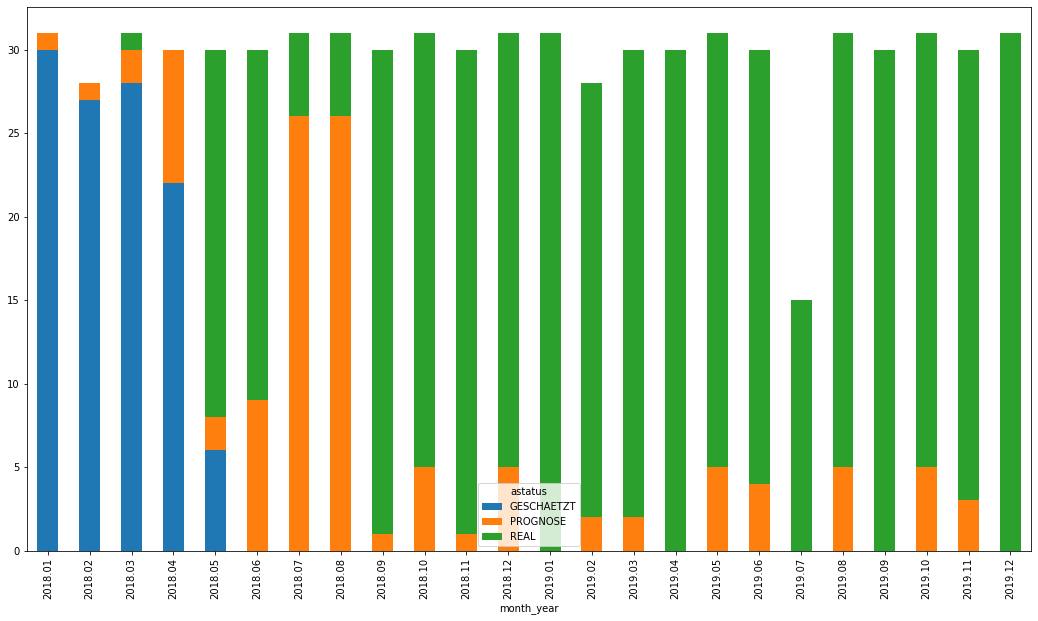

In [189]:
pivot_df = df.pivot(index='month_year', columns='astatus', values='count')
pivot_df.plot.bar(stacked=True, figsize=(18,10))
plt.show()

ii) Show how the monthly distribution of `AN_PROGNOSE_STATUS` for all the trains that arrived at Lausanne station. Document any anything you observed.

In [191]:
query = """
    select date_format(TO_DATE(FROM_UNIXTIME(UNIX_TIMESTAMP(BETRIEBSTAG, 'dd.MM.yyyy'))),'yyyy.MM') as month_year, AN_PROGNOSE_STATUS as astatus,count(*) as count 
    from {0}.sbb_orc
    where HALTESTELLEN_NAME like 'Lausanne'
    group by date_format(TO_DATE(FROM_UNIXTIME(UNIX_TIMESTAMP(BETRIEBSTAG, 'dd.MM.yyyy'))),'yyyy.MM'), AN_PROGNOSE_STATUS
    order by month_year
""".format(username)
df_lausanne = pd.read_sql(query, conn)
# substr(betriebstag,4,8) as month_year,

In [192]:
df_lausanne.head()

,month_year,astatus,count
0,2018.01,PROGNOSE,3595
1,2018.01,UNBEKANNT,2
2,2018.01,GESCHAETZT,13208
3,2018.02,PROGNOSE,3270
4,2018.02,GESCHAETZT,12017


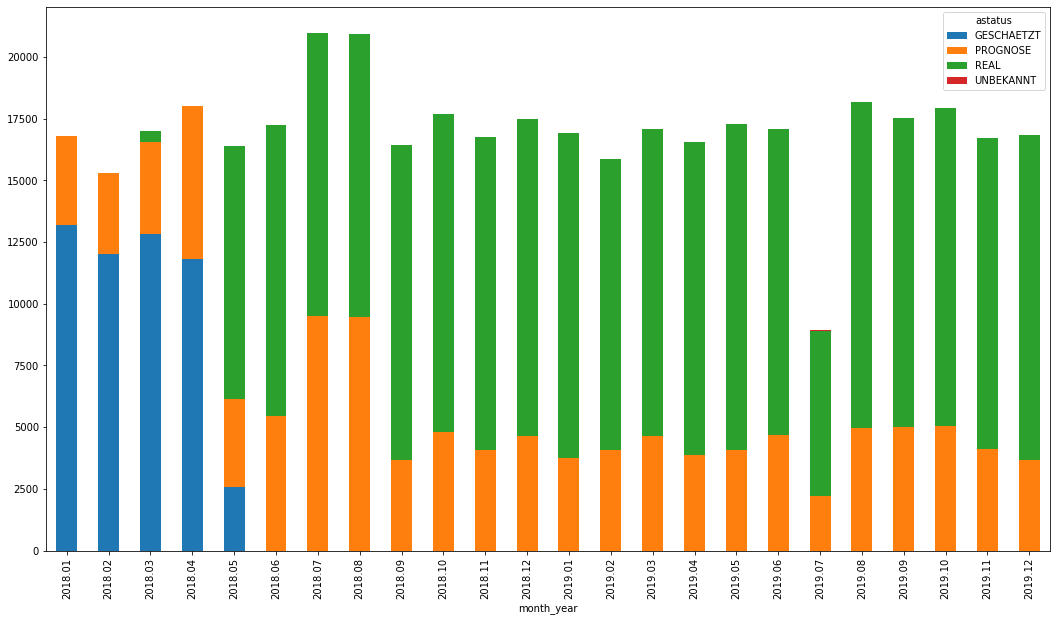

In [193]:
pivot_df = df_lausanne.pivot(index='month_year', columns='astatus', values='count')
pivot_df.plot.bar(stacked=True, figsize=(18,10))
plt.show()

### Question I.d - 20 Points

In this question, use __REAL__ for `AN_PROGNOSE_STATUS` and `AB_PROGNOSE_STATUS`.

i) Display the distribution of delays for the __IC 733__ train at the Lausanne train station. Select the information from the database as a "histogram" with bin size of one minute and plot it in a proper way.

__Note:__ when the train is ahead of schedule, count this as a delay of 0.

ii) Compute the 50th and 75th percentiles of delays for IC 702, 704, ..., 728, 730 (15 trains total) at Genève main station. Which trains are the most disrupted? Can you find the tendency and interpret?

iii) Compute 25th, 50th and 75th percentiles of delays for all trains departing Lausanne gare within each hour and visualize your results. Can you find the tendency and interpret?

iv) Did you notice something "strange"? Can you try to find the reasons behind that? Feel free to check it out from different perspectives.

### Question I.f - 15 Points

If the departure time of one train is delayed, can it catch up with the schedule at a later station? Select __at least 2 trains from Genève (main station) to Lausanne gare__ as examples. Think about what kind of trains you want to select, direct or indirect (having stops in between), at rush hour or in midnight? Use HiveQL to select relevant data and show the results with a proper plot of arrival delay at Lausanne versus departure delay at Genève. Document and discuss your findings.

__Note__: you can write some helper functions to generate the query for you.

In [ ]:
query = """
    SELECT *
    FROM {0}.sbb_orc
    LIMIT 500
""".format(username)
pd.read_sql(query,conn)